In [ ]:
import sklearn
import xgboost
from alembic.command import heads

print("scikit-learn version:", sklearn.__version__)
print("xgboost version:", xgboost.__version__)
# pip install xgboost==1.6.0
# pip install scikit-learn==1.2.1

In [2]:
import numpy as np
import pandas as pd

## Obtain the train and test data

In [3]:
train = pd.read_excel(r'E:\A_workbench\A-lab\25-2-4\Human-Activity-Recognition-master\my_data\train_dataset.xlsx')
test = pd.read_excel(r'E:\A_workbench\A-lab\25-2-4\Human-Activity-Recognition-master\my_data\test_dataset.xlsx')

In [4]:
print(train.shape, test.shape)

(16482, 883) (5635, 883)


In [5]:
print(train.head(5))

   tAccelerometer_X_mean  tAccelerometer_X_std  tAccelerometer_X_mad  \
0              -0.005355              0.066856              0.036765   
1              -0.005292              0.049632              0.025016   
2               0.008141              0.045348              0.027677   
3               0.050977              0.153627              0.042061   
4              -0.116075              0.447143              0.224372   

   tAccelerometer_X_max  tAccelerometer_X_min  tAccelerometer_X_sma  \
0              0.174204             -0.198227              6.364118   
1              0.117290             -0.198227              4.598944   
2              0.129252             -0.158697              4.446158   
3              0.600533             -0.452172             12.498151   
4              0.632339             -1.532125             41.125657   

   tAccelerometer_X_energy  tAccelerometer_X_iqr  tAccelerometer_X_entropy  \
0                 0.004498              0.072515              

In [17]:
# get X_train and y_train from csv files
X_train = train.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_train = train.Activity

In [18]:
# get X_test and y_test from test csv file
X_test = test.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_test = test.Activity

In [19]:
print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))
print('X_test  and y_test  : ({},{})'.format(X_test.shape, y_test.shape))

X_train and y_train : ((16482, 880),(16482,))
X_test  and y_test  : ((5635, 880),(5635,))


In [20]:
from sklearn.model_selection import train_test_split

# 使用 stratify 参数来保证类别平均 
X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.9, random_state=42, stratify=y_train)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)
 
# 打印数据形状 
print('X_train and y_train : ({},{})'.format(X_train.shape,  y_train.shape))
print('X_temp and y_temp : ({},{})'.format(X_temp.shape,  y_temp.shape))
print('X_val  and y_val   : ({},{})'.format(X_val.shape,  y_val.shape)) 
print('X_test and y_test  : ({},{})'.format(X_test.shape,  y_test.shape)) 

X_train and y_train : ((1648, 880),(1648,))
X_temp and y_temp : ((14834, 880),(14834,))
X_val  and y_val   : ((2818, 880),(2818,))
X_test and y_test  : ((2817, 880),(2817,))


# Let's model with our data

### Labels that are useful in plotting confusion matrix

In [21]:
labels=['Standing', 'Walking','Transitional movements','Bending','Squatting']

### Function to plot the confusion matrix

In [22]:
import matplotlib
print("matplotlib version:", matplotlib.__version__)


matplotlib version: 3.6.0


In [23]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
plt.rcParams["font.family"] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    ax = plt.gca()
    ax.set_ylim(-.5, 5.5)
        
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Generic function to run any model specified

In [24]:
from datetime import datetime
from memory_profiler import memory_usage

def perform_model(model, X_train, y_train, X_test, y_test, class_labels, cm_normalize=True, \
                 print_cm=True, cm_cmap=plt.cm.Reds): 
    
    # 用于存储各个阶段的结果
    results = dict()
    
    # 模型开始训练的时间
    train_start_time = datetime.now() 
    print('训练模型中..')
    
    # 监控训练阶段的内存使用
    mem_usage_train = memory_usage((model.fit, (X_train, y_train)), interval=0.1)
    results['train_memory_usage'] = max(mem_usage_train)
    
    print('完成 \n \n')
    train_end_time = datetime.now() 
    
    # 计算并存储训练时间
    results['training_time'] = train_end_time - train_start_time
    # 输出训练时间，格式为时:分:秒.毫秒
    print('训练时间(HH:MM:SS.ms)  - {}\n\n'.format(results['training_time']))
    print('训练阶段最大内存使用: {:.2f} MB\n\n'.format(results['train_memory_usage']))
    
    # 预测测试数据
    print('预测测试数据')
    test_start_time = datetime.now() 
    
    # 监控测试阶段的内存使用
    mem_usage_test = memory_usage((model.predict, (X_test,)), interval=0.1)
    results['test_memory_usage'] = max(mem_usage_test)
    
    y_pred = model.predict(X_test) 
    test_end_time = datetime.now() 
    print('完成 \n \n')
    results['testing_time'] = test_end_time - test_start_time
    print('测试时间(HH:MM:SS.ms)  - {}\n\n'.format(results['testing_time']))
    print('测试阶段最大内存使用: {:.2f} MB\n\n'.format(results['test_memory_usage']))
    
    results['predicted'] = y_pred
   
    # 计算模型的整体准确率
    accuracy = metrics.accuracy_score(y_true=y_test,  y_pred=y_pred)
    # 存储准确率
    results['accuracy'] = accuracy
    print('---------------------')
    print('|      准确率       |')
    print('---------------------')
    print('\n    {}\n\n'.format(accuracy))
    
    # 混淆矩阵
    cm = metrics.confusion_matrix(y_test,  y_pred)
    results['confusion_matrix'] = cm
    if print_cm: 
        print('--------------------')
        print('| 混淆矩阵 |')
        print('--------------------')
        print('\n {}'.format(cm))
        
    # 绘制混淆矩阵
    plt.figure(figsize=(8,8)) 
    plt.grid(b=False) 
    plot_confusion_matrix(cm, classes=class_labels, normalize=cm_normalize, title='归一化混淆矩阵', cmap=cm_cmap)
    ax = plt.gca() 
    ax.set_ylim(-.5,5.5) 
    plt.show() 
    
    # 获取分类报告
    print('-------------------------')
    print('| 分类报告 |')
    print('-------------------------')
    classification_report = metrics.classification_report(y_test,  y_pred)
    # 存储分类报告
    results['classification_report'] = classification_report
    print(classification_report)
    
    # 将训练好的模型添加到结果中
    results['model'] = model
    
    return results
    

### Method to print the gridsearch Attributes

In [25]:
def print_grid_search_attributes(model):
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('--------------------------')
    print('|      Best Estimator     |')
    print('--------------------------')
    print('\n\t{}\n'.format(model.best_estimator_))


    # parameters that gave best results while performing grid search
    print('--------------------------')
    print('|     Best parameters     |')
    print('--------------------------')
    print('\tParameters of best estimator : \n\n\t{}\n'.format(model.best_params_))


    #  number of cross validation splits
    print('---------------------------------')
    print('|   No of CrossValidation sets   |')
    print('--------------------------------')
    print('\n\tTotal numbre of cross validation sets: {}\n'.format(model.n_splits_))


    # Average cross validated score of the best estimator, from the Grid Search 
    print('--------------------------')
    print('|        Best Score       |')
    print('--------------------------')
    print('\n\tAverage Cross Validate scores of best estimator : \n\n\t{}\n'.format(model.best_score_))

    
    

In [26]:
y_train

9530     5
1033     1
12156    1
5602     5
13877    1
        ..
9112     5
9209     5
1039     4
15655    4
16314    1
Name: Activity, Length: 1648, dtype: int64

# 1. Logistic Regression with Grid Search

In [27]:
from sklearn import linear_model
from sklearn import metrics

from sklearn.model_selection import GridSearchCV

训练模型中..
Fitting 3 folds for each of 12 candidates, totalling 36 fits


E:\Anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
18 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "E:\Anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "E:\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py", line 54, in _check_solver
    raise ValueError(
V

完成 
 

训练时间(HH:MM:SS.ms)  - 0:00:08.204821


训练阶段最大内存使用: 561.25 MB


预测测试数据
完成 
 

测试时间(HH:MM:SS.ms)  - 0:00:03.107831


测试阶段最大内存使用: 583.93 MB


---------------------
|      准确率       |
---------------------

    0.7326943556975506


--------------------
| 混淆矩阵 |
--------------------

 [[1972    0    1   16   36]
 [ 296    0    0    1    3]
 [  81    0    0    2   27]
 [  86    0    0    0   10]
 [ 182    0    0   12   92]]


C:\Users\yuyu\AppData\Local\Temp\ipykernel_40260\3027523060.py:64: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)
C:\Users\yuyu\AppData\Local\Temp\ipykernel_40260\3315235828.py:30: UserWarning: Glyph 24402 (\N{CJK UNIFIED IDEOGRAPH-5F52}) missing from current font.
  plt.tight_layout()
C:\Users\yuyu\AppData\Local\Temp\ipykernel_40260\3315235828.py:30: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from current font.
  plt.tight_layout()
C:\Users\yuyu\AppData\Local\Temp\ipykernel_40260\3315235828.py:30: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from current font.
  plt.tight_layout()
C:\Users\yuyu\AppData\Local\Temp\ipykernel_40260\3315235828.py:30: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from current font.
  plt.tight_layout()
C:\Users\yuyu\AppData\Local\Temp\ipykernel_4026

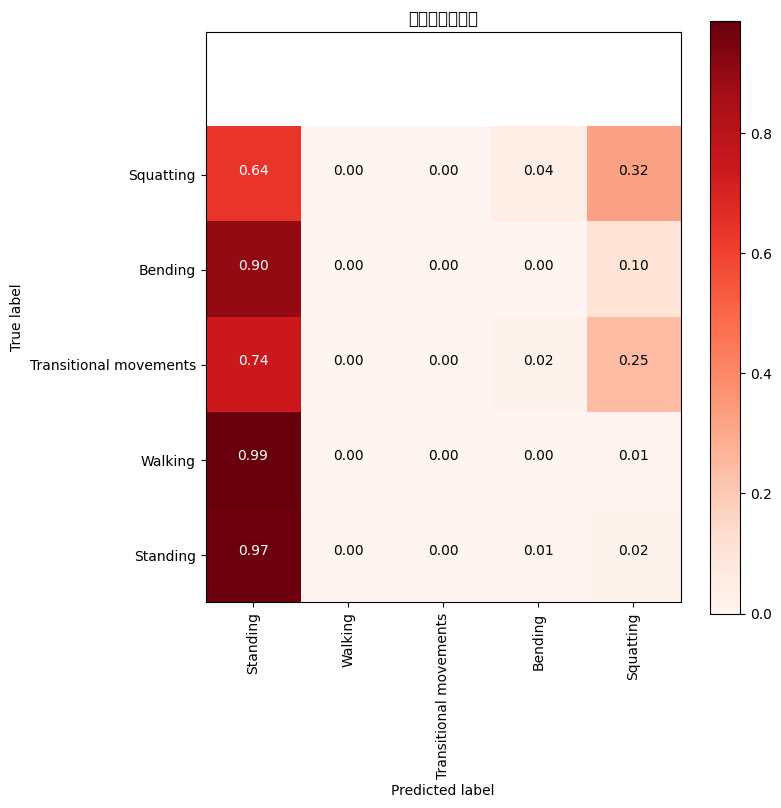

-------------------------
| 分类报告 |
-------------------------
              precision    recall  f1-score   support

           1       0.75      0.97      0.85      2025
           2       0.00      0.00      0.00       300
           3       0.00      0.00      0.00       110
           4       0.00      0.00      0.00        96
           5       0.55      0.32      0.41       286

    accuracy                           0.73      2817
   macro avg       0.26      0.26      0.25      2817
weighted avg       0.60      0.73      0.65      2817



E:\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:

# start Grid search
parameters = {'C':[0.01, 0.1, 1, 10, 20, 30], 'penalty':['l2','l1']}
log_reg = linear_model.LogisticRegression()
log_reg_grid = GridSearchCV(log_reg, param_grid=parameters, cv=3, verbose=1, n_jobs=-1)
log_reg_grid_results =  perform_model(log_reg_grid, X_train, y_train, X_test, y_test, class_labels=labels)



C:\Users\yuyu\AppData\Local\Temp\ipykernel_40260\181114546.py:2: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)


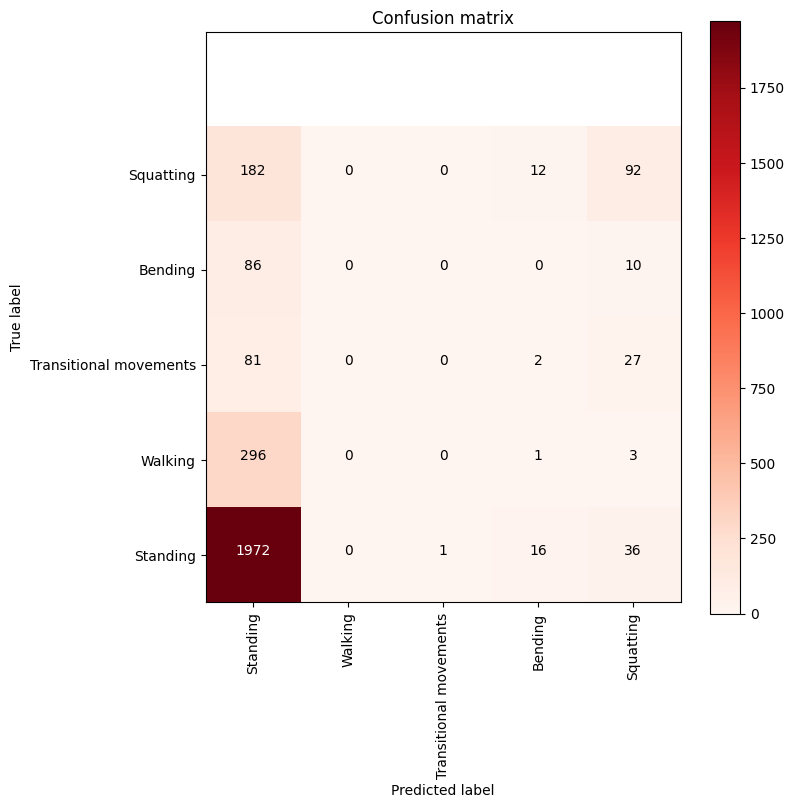

In [29]:
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(log_reg_grid_results['confusion_matrix'], classes=labels, cmap=plt.cm.Reds, )

plt.show()

In [30]:
# observe the attributes of the model 
print_grid_search_attributes(log_reg_grid_results['model'])

--------------------------
|      Best Estimator     |
--------------------------

	LogisticRegression(C=0.1)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'C': 0.1, 'penalty': 'l2'}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 3

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.674769553458078



# 2. KNN with GridSearch

训练模型中..
Fitting 3 folds for each of 5 candidates, totalling 15 fits
完成 
 

训练时间(HH:MM:SS.ms)  - 0:00:01.159768


训练阶段最大内存使用: 564.40 MB


预测测试数据
完成 
 

测试时间(HH:MM:SS.ms)  - 0:00:01.296224


测试阶段最大内存使用: 591.80 MB


---------------------
|      准确率       |
---------------------

    0.53177138800142


--------------------
| 混淆矩阵 |
--------------------

 [[  17   20   49   10    0]
 [  65   72  101   40    8]
 [ 151  253 1378  106  137]
 [   8   30   44   13   15]
 [  10   51  197   24   18]]


C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\3027523060.py:64: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)
C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\3315235828.py:30: UserWarning: Glyph 24402 (\N{CJK UNIFIED IDEOGRAPH-5F52}) missing from current font.
  plt.tight_layout()
C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\3315235828.py:30: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from current font.
  plt.tight_layout()
C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\3315235828.py:30: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from current font.
  plt.tight_layout()
C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\3315235828.py:30: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from current font.
  plt.tight_layout()
C:\Users\yuyu\AppData\Local\Temp\ipykernel_3494

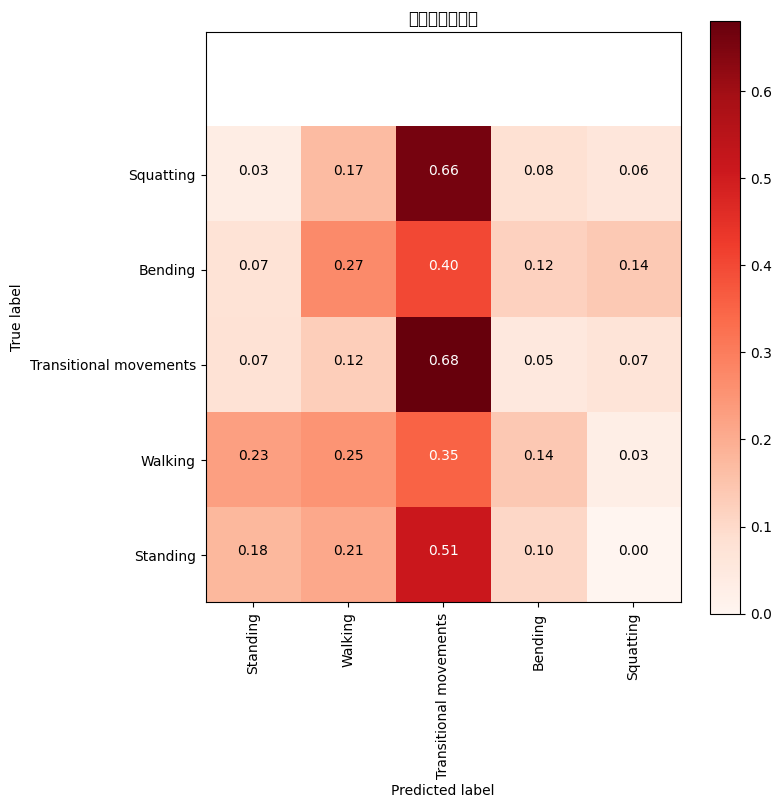

-------------------------
| 分类报告 |
-------------------------
                        precision    recall  f1-score   support

               Bending       0.07      0.18      0.10        96
             Squatting       0.17      0.25      0.20       286
              Standing       0.78      0.68      0.73      2025
Transitional movements       0.07      0.12      0.09       110
               Walking       0.10      0.06      0.08       300

              accuracy                           0.53      2817
             macro avg       0.24      0.26      0.24      2817
          weighted avg       0.59      0.53      0.56      2817



In [19]:
from sklearn.neighbors import KNeighborsClassifier

#knn
# start Grid search
parameters = {'n_neighbors': [1, 10, 11, 20, 30]}
log_knn = KNeighborsClassifier(n_neighbors=6)

log_knn_grid = GridSearchCV(log_knn, param_grid=parameters, cv=3, verbose=1, n_jobs=-1)
log_knn_grid_results =  perform_model(log_knn_grid, X_train, y_train, X_test, y_test, class_labels=labels)


C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\2556982687.py:2: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)


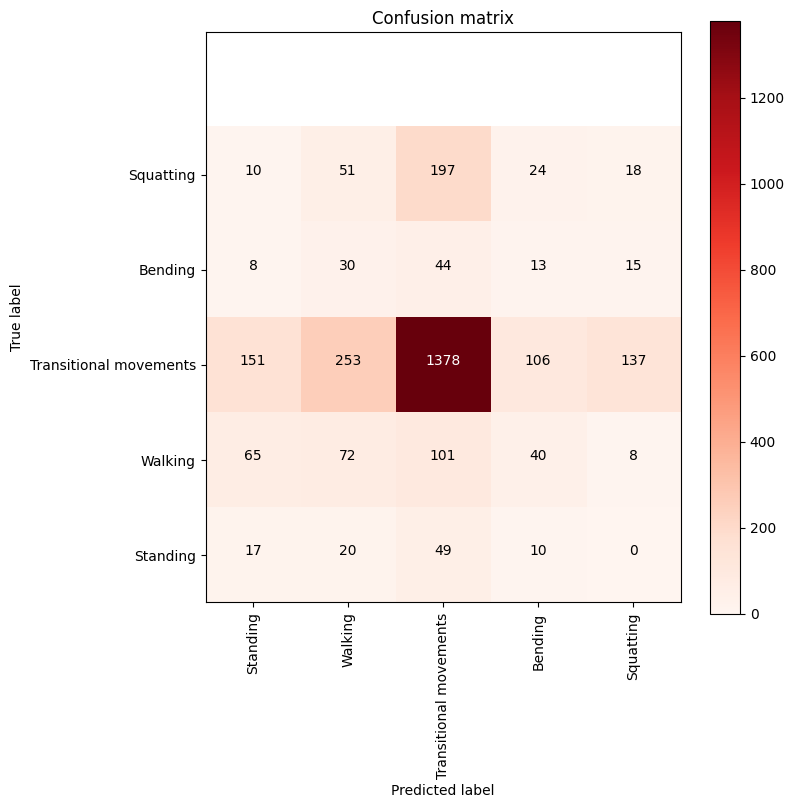

In [20]:
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(log_knn_grid_results['confusion_matrix'], classes=labels, cmap=plt.cm.Reds, )

plt.show()

In [21]:
# observe the attributes of the model 
print_grid_search_attributes(log_knn_grid_results['model'])

--------------------------
|      Best Estimator     |
--------------------------

	KNeighborsClassifier(n_neighbors=1)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'n_neighbors': 1}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 3

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.6947949439752718



#  3. Linear SVC with GridSearch

In [22]:
from sklearn.svm import LinearSVC

训练模型中..
Fitting 5 folds for each of 2 candidates, totalling 10 fits


E:\Anaconda3\envs\pytorch\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


完成 
 

训练时间(HH:MM:SS.ms)  - 0:00:39.609984


训练阶段最大内存使用: 610.83 MB


预测测试数据
完成 
 

测试时间(HH:MM:SS.ms)  - 0:00:02.207406


测试阶段最大内存使用: 596.75 MB


---------------------
|      准确率       |
---------------------

    0.1270855520056798


--------------------
| 混淆矩阵 |
--------------------

 [[   0    0    0   96    0]
 [   0    0    0  286    0]
 [   0    2  249 1774    0]
 [   0    2    0  107    1]
 [   0    0    2  296    2]]


C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\3027523060.py:64: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)
C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\3315235828.py:30: UserWarning: Glyph 24402 (\N{CJK UNIFIED IDEOGRAPH-5F52}) missing from current font.
  plt.tight_layout()
C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\3315235828.py:30: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from current font.
  plt.tight_layout()
C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\3315235828.py:30: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from current font.
  plt.tight_layout()
C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\3315235828.py:30: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from current font.
  plt.tight_layout()
C:\Users\yuyu\AppData\Local\Temp\ipykernel_3494

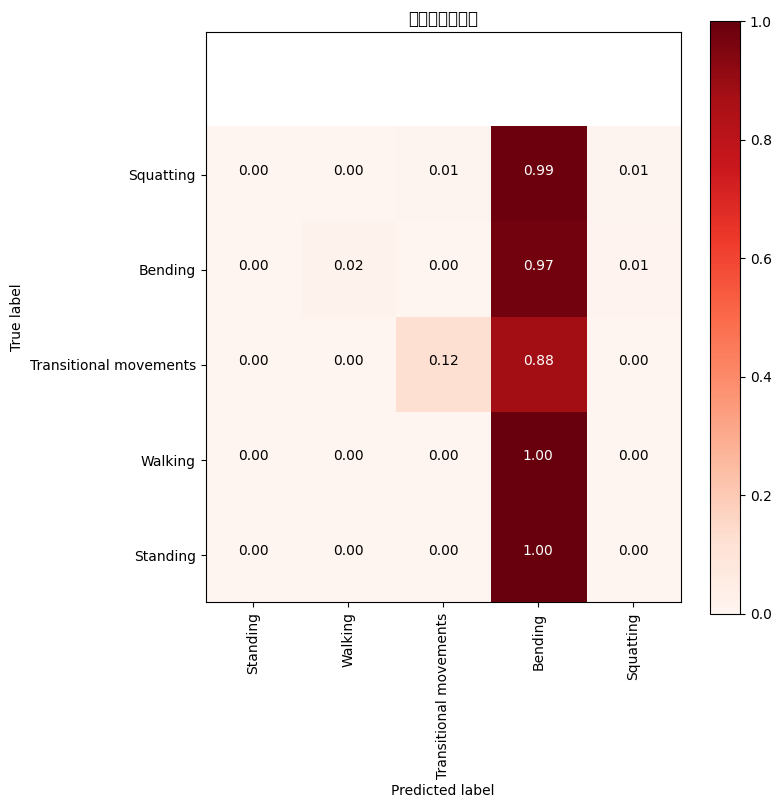

-------------------------
| 分类报告 |
-------------------------


E:\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

               Bending       0.00      0.00      0.00        96
             Squatting       0.00      0.00      0.00       286
              Standing       0.99      0.12      0.22      2025
Transitional movements       0.04      0.97      0.08       110
               Walking       0.67      0.01      0.01       300

              accuracy                           0.13      2817
             macro avg       0.34      0.22      0.06      2817
          weighted avg       0.79      0.13      0.16      2817



E:\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
parameters = {'C':[0.125, 0.5]}
lr_svc = LinearSVC(tol=0.00005)
lr_svc_grid = GridSearchCV(lr_svc, param_grid=parameters, n_jobs=-1, verbose=1)
lr_svc_grid_results = perform_model(lr_svc_grid, X_train, y_train, X_test, y_test, class_labels=labels)

In [24]:
print_grid_search_attributes(lr_svc_grid_results['model'])

--------------------------
|      Best Estimator     |
--------------------------

	LinearSVC(C=0.5, tol=5e-05)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'C': 0.5}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 5

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.6292272266740352



# 4.  Kernel SVM with GridSearch

训练模型中..
完成 
 

训练时间(HH:MM:SS.ms)  - 0:00:14.585521


训练阶段最大内存使用: 594.55 MB


预测测试数据
完成 
 

测试时间(HH:MM:SS.ms)  - 0:00:06.923838


测试阶段最大内存使用: 612.49 MB


---------------------
|      准确率       |
---------------------

    0.7188498402555911


--------------------
| 混淆矩阵 |
--------------------

 [[   0    0   96    0    0]
 [   0    0  286    0    0]
 [   0    0 2025    0    0]
 [   0    0  110    0    0]
 [   0    0  300    0    0]]


C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\3027523060.py:64: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)
C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\3315235828.py:30: UserWarning: Glyph 24402 (\N{CJK UNIFIED IDEOGRAPH-5F52}) missing from current font.
  plt.tight_layout()
C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\3315235828.py:30: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from current font.
  plt.tight_layout()
C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\3315235828.py:30: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from current font.
  plt.tight_layout()
C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\3315235828.py:30: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from current font.
  plt.tight_layout()
C:\Users\yuyu\AppData\Local\Temp\ipykernel_3494

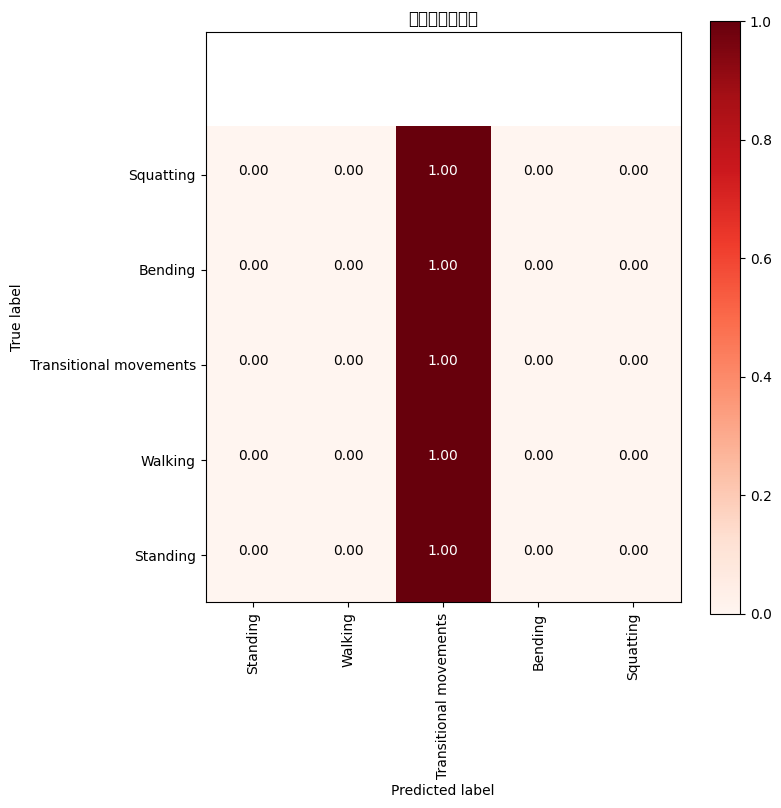

-------------------------
| 分类报告 |
-------------------------
                        precision    recall  f1-score   support

               Bending       0.00      0.00      0.00        96
             Squatting       0.00      0.00      0.00       286
              Standing       0.72      1.00      0.84      2025
Transitional movements       0.00      0.00      0.00       110
               Walking       0.00      0.00      0.00       300

              accuracy                           0.72      2817
             macro avg       0.14      0.20      0.17      2817
          weighted avg       0.52      0.72      0.60      2817



E:\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
from sklearn.svm import SVC
parameters = {'C':[2,8],\
              'gamma': [0.125, 2]}
rbf_svm = SVC(kernel='rbf')
rbf_svm_grid = GridSearchCV(rbf_svm,param_grid=parameters, n_jobs=-1)
rbf_svm_grid_results = perform_model(rbf_svm_grid, X_train, y_train, X_test, y_test, class_labels=labels)

In [26]:
print_grid_search_attributes(rbf_svm_grid_results['model'])

--------------------------
|      Best Estimator     |
--------------------------

	SVC(C=2, gamma=0.125)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'C': 2, 'gamma': 0.125}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 5

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.49393202542138714



# 5. Decision Trees with GridSearchCV

训练模型中..
完成 
 

训练时间(HH:MM:SS.ms)  - 0:00:02.036015


训练阶段最大内存使用: 600.09 MB


预测测试数据
完成 
 

测试时间(HH:MM:SS.ms)  - 0:00:02.237136


测试阶段最大内存使用: 622.93 MB


---------------------
|      准确率       |
---------------------

    0.8739794107206248


--------------------
| 混淆矩阵 |
--------------------

 [[   6    6   83    0    1]
 [   8  253   24    0    1]
 [   0    0 2013    0   12]
 [   3   23   64    6   14]
 [   0    2  113    1  184]]


C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\3027523060.py:64: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)
C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\3315235828.py:30: UserWarning: Glyph 24402 (\N{CJK UNIFIED IDEOGRAPH-5F52}) missing from current font.
  plt.tight_layout()
C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\3315235828.py:30: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from current font.
  plt.tight_layout()
C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\3315235828.py:30: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from current font.
  plt.tight_layout()
C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\3315235828.py:30: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from current font.
  plt.tight_layout()
C:\Users\yuyu\AppData\Local\Temp\ipykernel_3494

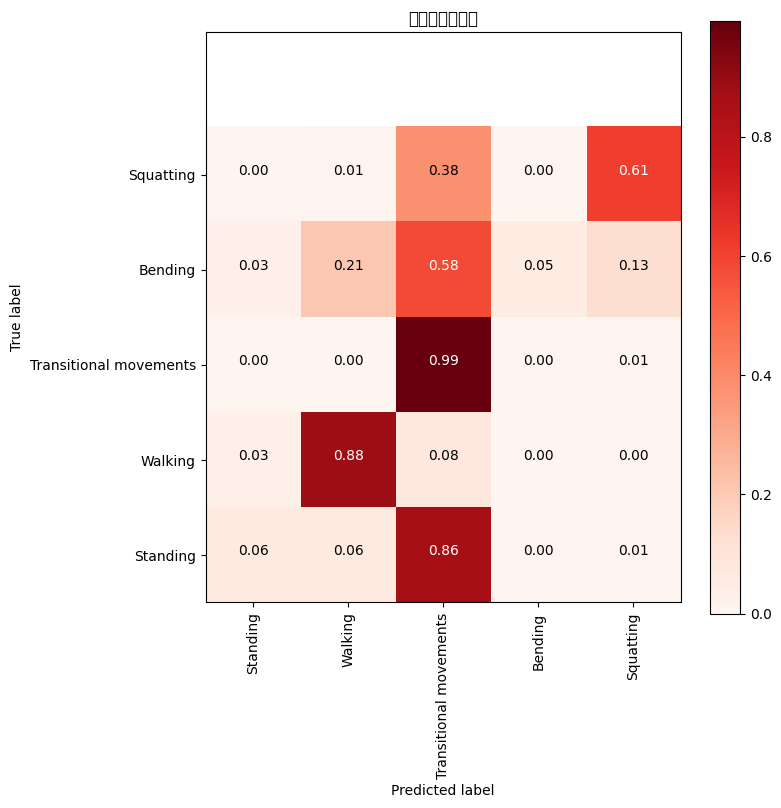

-------------------------
| 分类报告 |
-------------------------
                        precision    recall  f1-score   support

               Bending       0.35      0.06      0.11        96
             Squatting       0.89      0.88      0.89       286
              Standing       0.88      0.99      0.93      2025
Transitional movements       0.86      0.05      0.10       110
               Walking       0.87      0.61      0.72       300

              accuracy                           0.87      2817
             macro avg       0.77      0.52      0.55      2817
          weighted avg       0.86      0.87      0.84      2817

--------------------------
|      Best Estimator     |
--------------------------

	DecisionTreeClassifier(max_depth=5)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'max_depth': 5}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	

In [27]:
from sklearn.tree import DecisionTreeClassifier
parameters = {'max_depth':np.arange(3,6,2)}
dt = DecisionTreeClassifier()
dt_grid = GridSearchCV(dt,param_grid=parameters, n_jobs=-1)
dt_grid_results = perform_model(dt_grid, X_train, y_train, X_test, y_test, class_labels=labels)
print_grid_search_attributes(dt_grid_results['model'])

# 6. Random Forest Classifier with GridSearch

训练模型中..
完成 
 

训练时间(HH:MM:SS.ms)  - 0:01:47.957524


训练阶段最大内存使用: 604.11 MB


预测测试数据
完成 
 

测试时间(HH:MM:SS.ms)  - 0:00:01.353536


测试阶段最大内存使用: 608.42 MB


---------------------
|      准确率       |
---------------------

    0.8374156904508342


--------------------
| 混淆矩阵 |
--------------------

 [[  12    2   80    2    0]
 [  95  157   32    2    0]
 [   1    0 2020    0    4]
 [  13   18   51   24    4]
 [   2    0  148    4  146]]


C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\3027523060.py:64: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)
C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\3315235828.py:30: UserWarning: Glyph 24402 (\N{CJK UNIFIED IDEOGRAPH-5F52}) missing from current font.
  plt.tight_layout()
C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\3315235828.py:30: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from current font.
  plt.tight_layout()
C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\3315235828.py:30: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from current font.
  plt.tight_layout()
C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\3315235828.py:30: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from current font.
  plt.tight_layout()
C:\Users\yuyu\AppData\Local\Temp\ipykernel_3494

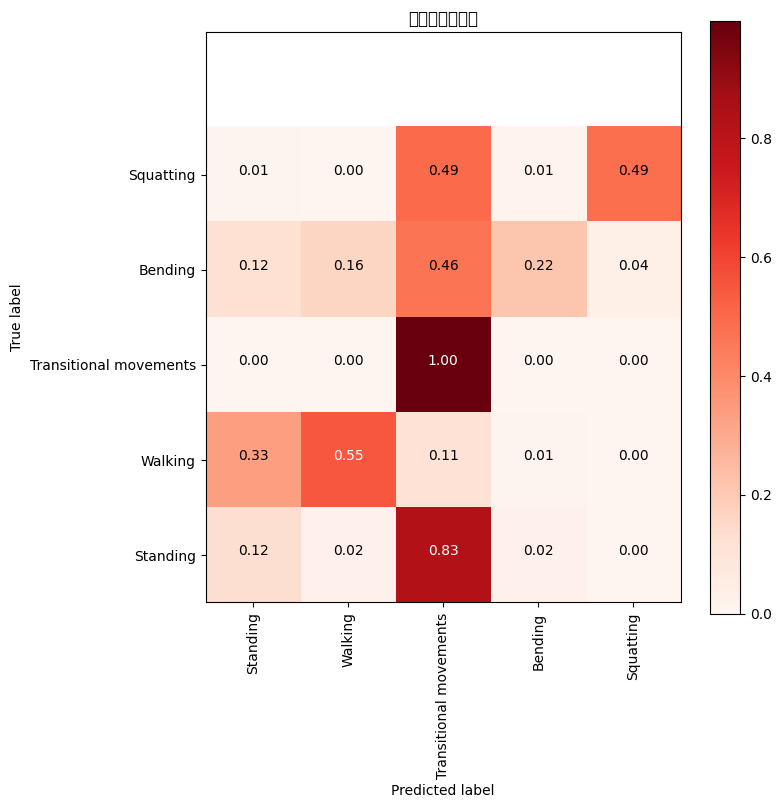

-------------------------
| 分类报告 |
-------------------------
                        precision    recall  f1-score   support

               Bending       0.10      0.12      0.11        96
             Squatting       0.89      0.55      0.68       286
              Standing       0.87      1.00      0.93      2025
Transitional movements       0.75      0.22      0.34       110
               Walking       0.95      0.49      0.64       300

              accuracy                           0.84      2817
             macro avg       0.71      0.48      0.54      2817
          weighted avg       0.85      0.84      0.82      2817

--------------------------
|      Best Estimator     |
--------------------------

	RandomForestClassifier(max_depth=13, n_estimators=130)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'max_depth': 13, 'n_estimators': 130}

---------------------------------
|   No of CrossValidation set

In [28]:
from sklearn.ensemble import RandomForestClassifier
params = {'n_estimators': np.arange(10,201,20), 'max_depth':np.arange(3,15,2)}
rfc = RandomForestClassifier()
rfc_grid = GridSearchCV(rfc, param_grid=params, n_jobs=-1)
rfc_grid_results = perform_model(rfc_grid, X_train, y_train, X_test, y_test, class_labels=labels)
print_grid_search_attributes(rfc_grid_results['model'])

# 7.  Gradient Boosted Decision Trees With GridSearch

训练模型中..
完成 
 

训练时间(HH:MM:SS.ms)  - 0:18:09.897593


训练阶段最大内存使用: 610.14 MB


预测测试数据
完成 
 

测试时间(HH:MM:SS.ms)  - 0:00:01.296583


测试阶段最大内存使用: 615.38 MB


---------------------
|      准确率       |
---------------------

    0.8413205537806177


--------------------
| 混淆矩阵 |
--------------------

 [[   9    1   81    2    3]
 [  79  160   45    2    0]
 [   0    0 2021    0    4]
 [  12    9   59   28    2]
 [   1    0  142    5  152]]


C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\3027523060.py:64: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)
C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\3315235828.py:30: UserWarning: Glyph 24402 (\N{CJK UNIFIED IDEOGRAPH-5F52}) missing from current font.
  plt.tight_layout()
C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\3315235828.py:30: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from current font.
  plt.tight_layout()
C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\3315235828.py:30: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from current font.
  plt.tight_layout()
C:\Users\yuyu\AppData\Local\Temp\ipykernel_34940\3315235828.py:30: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from current font.
  plt.tight_layout()
C:\Users\yuyu\AppData\Local\Temp\ipykernel_3494

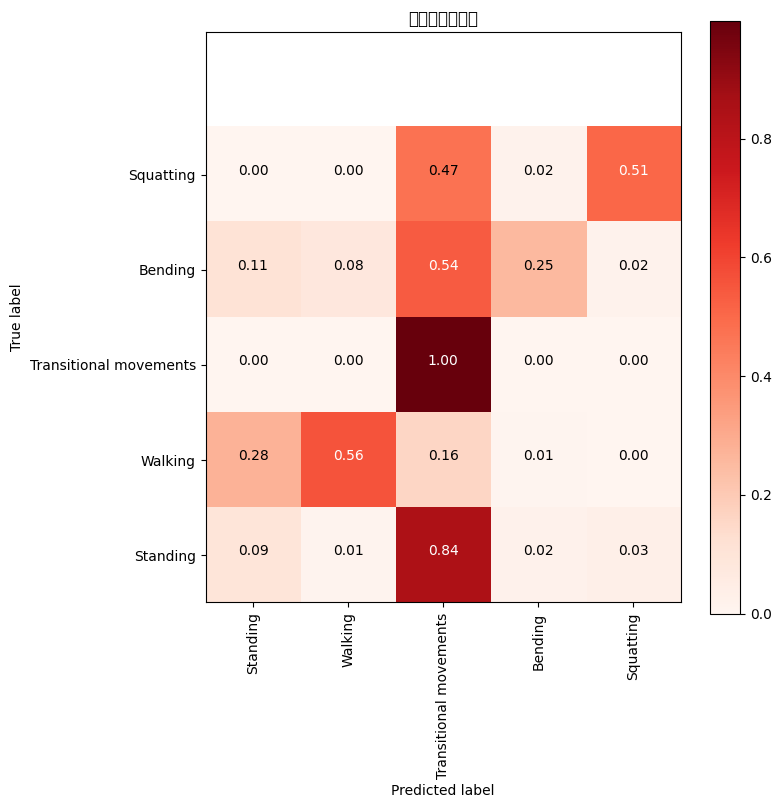

-------------------------
| 分类报告 |
-------------------------
                        precision    recall  f1-score   support

               Bending       0.09      0.09      0.09        96
             Squatting       0.94      0.56      0.70       286
              Standing       0.86      1.00      0.92      2025
Transitional movements       0.76      0.25      0.38       110
               Walking       0.94      0.51      0.66       300

              accuracy                           0.84      2817
             macro avg       0.72      0.48      0.55      2817
          weighted avg       0.85      0.84      0.82      2817

--------------------------
|      Best Estimator     |
--------------------------

	GradientBoostingClassifier(max_depth=5, n_estimators=130)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'max_depth': 5, 'n_estimators': 130}

---------------------------------
|   No of CrossValidation s

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
param_grid = {'max_depth': np.arange(5,6,1), \
             'n_estimators':np.arange(130,140,10)}
gbdt = GradientBoostingClassifier()
gbdt_grid = GridSearchCV(gbdt, param_grid=param_grid, n_jobs=-1)
gbdt_grid_results = perform_model(gbdt_grid, X_train, y_train, X_test, y_test, class_labels=labels)
print_grid_search_attributes(gbdt_grid_results['model'])

In [31]:
import numpy as np 
from sklearn.model_selection  import GridSearchCV 
from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [32]:
import xgboost
print(xgboost.__version__)  # 需要 >= 1.6.0


1.6.0


In [38]:
param_grid_lgb = { 
    'num_leaves': np.arange(31,  41, 5), 
    'n_estimators': np.arange(100,  121, 20) 
}
lgb_model = LGBMClassifier() 
lgb_grid = GridSearchCV(lgb_model, param_grid=param_grid_lgb, n_jobs=-1)
lgb_results = perform_model(lgb_grid, X_train, y_train, X_test, y_test, class_labels=labels) 
print_grid_search_attributes(lgb_results['model'])

训练模型中..


OSError: [Errno 22] Invalid argument

In [39]:
param_grid_cat = {
    'depth': np.arange(4, 5, 1), 
    'iterations': np.arange(100,  121, 20)
}
cat_model = CatBoostClassifier(verbose=0) 
cat_grid = GridSearchCV(cat_model, param_grid=param_grid_cat, n_jobs=-1) 
cat_results = perform_model(cat_grid, X_train, y_train, X_test, y_test, class_labels=labels) 
print_grid_search_attributes(cat_results['model']) 

训练模型中..


OSError: [Errno 22] Invalid argument

In [44]:
y_train = [x - 1 for x in y_train]
y_train

[3,
 -1,
 -1,
 3,
 -1,
 -1,
 3,
 -1,
 -1,
 1,
 3,
 -1,
 -1,
 -1,
 -1,
 2,
 3,
 0,
 -1,
 3,
 -1,
 -1,
 3,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 3,
 -1,
 -1,
 0,
 1,
 -1,
 -1,
 1,
 2,
 2,
 -1,
 -1,
 -1,
 3,
 -1,
 3,
 3,
 2,
 1,
 -1,
 3,
 2,
 3,
 2,
 0,
 3,
 -1,
 1,
 2,
 -1,
 -1,
 -1,
 0,
 2,
 3,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 3,
 -1,
 -1,
 -1,
 1,
 3,
 3,
 2,
 -1,
 3,
 2,
 -1,
 3,
 -1,
 -1,
 -1,
 -1,
 3,
 -1,
 1,
 0,
 -1,
 1,
 -1,
 3,
 3,
 2,
 2,
 -1,
 3,
 -1,
 -1,
 -1,
 3,
 -1,
 3,
 3,
 3,
 3,
 -1,
 1,
 -1,
 -1,
 2,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 2,
 3,
 3,
 3,
 3,
 1,
 3,
 -1,
 1,
 -1,
 -1,
 1,
 3,
 -1,
 -1,
 3,
 -1,
 1,
 2,
 2,
 -1,
 1,
 3,
 3,
 -1,
 -1,
 0,
 -1,
 2,
 -1,
 -1,
 2,
 3,
 -1,
 -1,
 3,
 -1,
 -1,
 -1,
 -1,
 0,
 -1,
 -1,
 0,
 1,
 -1,
 3,
 -1,
 -1,
 -1,
 -1,
 0,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 3,
 3,
 1,
 -1,
 2,
 2,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 2,
 3,
 -1,
 3,
 2,
 1,
 3,
 -1,
 3,
 3,
 -1,
 -1,
 0,
 3,
 -1,
 -1,
 -1,
 2,
 0,
 0,
 -1,
 -1,
 3,
 -1,
 1,
 3,
 0

In [45]:
param_grid_xgb = { 
    'max_depth': np.arange(3, 4, 1), 
    'n_estimators': np.arange(100,  121, 20) 
}

xgb_model = XGBClassifier() 
xgb_grid = GridSearchCV(xgb_model, param_grid=param_grid_xgb, n_jobs=-1)
xgb_results = perform_model(xgb_grid, X_train, y_train, X_test, y_test, class_labels=labels) 
print_grid_search_attributes(xgb_results['model'])

训练模型中..


OSError: [Errno 22] Invalid argument


# 8. Comparing all models

In [41]:
print('\n                     Accuracy     Error')
print('                     ----------   --------')
print('Logistic Regression : {:.04}%       {:.04}%'.format(log_reg_grid_results['accuracy'] * 100,\
                                                  100-(log_reg_grid_results['accuracy'] * 100)))

print('KNN : {:.04}%      {:.04}% '.format(log_knn_grid_results['accuracy'] * 100,\
                                                        100-(log_knn_grid_results['accuracy'] * 100)))

print('Linear SVC          : {:.04}%       {:.04}% '.format(lr_svc_grid_results['accuracy'] * 100,\
                                                        100-(lr_svc_grid_results['accuracy'] * 100)))

print('rbf SVM classifier  : {:.04}%      {:.04}% '.format(rbf_svm_grid_results['accuracy'] * 100,\
                                                          100-(rbf_svm_grid_results['accuracy'] * 100)))

print('DecisionTree        : {:.04}%      {:.04}% '.format(dt_grid_results['accuracy'] * 100,\
                                                        100-(dt_grid_results['accuracy'] * 100)))

print('Random Forest       : {:.04}%      {:.04}% '.format(rfc_grid_results['accuracy'] * 100,\
                                                           100-(rfc_grid_results['accuracy'] * 100)))
print('GradientBoosting DT : {:.04}%      {:.04}% '.format(rfc_grid_results['accuracy'] * 100,\
                                                        100-(rfc_grid_results['accuracy'] * 100)))

# print('XGBoost             : {:.04}%      {:.04}% '.format(xgb_results['accuracy'] * 100, 100 - (xgb_results['accuracy'] * 100))) 
 
# print('LightGBM            : {:.04}%      {:.04}% '.format(lgb_results['accuracy'] * 100, 100 - (lgb_results['accuracy'] * 100)))
 
# print('CatBoost            : {:.04}%      {:.04}% '.format(cat_results['accuracy'] * 100, 100 - (cat_results['accuracy'] * 100))) 


                     Accuracy     Error
                     ----------   --------
Logistic Regression : 72.24%       27.76%
KNN : 53.18%      46.82% 
Linear SVC          : 12.71%       87.29% 
rbf SVM classifier  : 71.88%      28.12% 
DecisionTree        : 87.4%      12.6% 
Random Forest       : 83.74%      16.26% 
GradientBoosting DT : 83.74%      16.26% 
